# Pricers

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Main functions
from src.Constants import *
from src.Utils import *

# Model simulation
from src.EquityModel import *
from src.BlackScholes import *
from src.Heston import *

from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *

# Pricing
from src.Pricer import *
from src.EuropeanPricer import *
from src.AsianPricer import *

## European option pricer

In [3]:
# Model parameters
S0 = 4
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

### Serial MC

In [12]:
# Define the European pricer
ep = EuropeanPricer(udl_model=model, preCompute=True, N_MC=int(100))

Pre-computing the equity trajectories


Sim. progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
ep

In [14]:
# Boolean representing whether the simulations have already been simulated
ep.isSimulated

True

In [15]:
K = 3.3 # Defining a strike price
# Call price
pricer_res = ep.compute_option_price(K=K, 
                                     contract=Constants.Contract.CALL, 
                                     ci_levels=[
                                         Constants.Level.LEVEL_80, 
                                         Constants.Level.LEVEL_85, 
                                         Constants.Level.LEVEL_90,
                                         Constants.Level.LEVEL_95,
                                         Constants.Level.LEVEL_99_9
                                     ])

Required CI levels:  [80, 85, 90, 95, 99.9]


In [17]:
# Call price
ep.compute_option_price_call(K)

Required CI levels:  [95]


{'price': 1.9408853405392725,
 'ci': {95: {'lower': 1.2737607770607549,
   'upper': 2.6080099040177904,
   'radius': 0.6671245634785177}}}

In [18]:
# Put price
ep.compute_option_price_put(K)

Required CI levels:  [95]


{'price': 0.24800880632262012,
 'ci': {95: {'lower': 0.16204041315612838,
   'upper': 0.33397719948911186,
   'radius': 0.08596839316649175}}}

### Parallel MC

<div style="background: red; padding: 10px 16px; color:white">
    <h3 style="border-bottom: 2px solid white">PERFORMANCE WARNING</h3>

<p>
    Parallelism allows us to speed up simulation of trajectory samples for $(S_t)_t$ and $(r_t)_t$ by e
    However, this enhancement has to be severely controlled to avoid any machine crashes.
    </p>
    
<p>
    If you choose to use parallel Monte-Carlo routines, <b>DO NOT</b> set a number of jobs greater than the number of logical CPU cores available on your local machine.
    </p>
    
<p>
    To obtain this information, please run:
    <code>Utils.get_multiprocessing_infos()["AVAILABLE_CPU_CORES"]</code>
    </p> 
<p>
    To track down the overall performance of the Python kernel and the underlying processes during the Monte-Carlo experiment, please execute in a terminale one of the following command: <code>top</code>, <code>htop</code> or <code>vtop</code>
    </p>
</div>

<div style="background: blue; padding: 10px 16px; color:white">
    <h3 style="border-bottom: 2px solid white">NOT A MULTITHREADED VERSION</h3>

<p>
    Because of the GIL feature of CPython interpreter (currently used in our project) and the fact that the MC simulations are classified as <b>CPU-bound instructions</b> rather than IO-bound instructions, it is more relevant to use processes instead of threads.
    </p>
    
<p>
    However, since the processes creation (spawn operator) is related to system operations (heavy cost), one may expect (and we indeed observed) <b>large overheads</b> on the overall performance.
    </p>
    
<p>
    As we have tested both <i>multithreading</i> and <i>multiprocessing</i>, one can point out the multiprocessing version reveals its advantages for large value of $N_{MC}$ (higher than $10^{4}$).
    </p>
  
</div>

In [19]:
# Retrieve the number of logical cores available on your machine
Utils.get_multiprocessing_infos()["AVAILABLE_CPU_CORES"]

8

<div style="background: red; padding: 10px 16px; color:white">
    <h3 style="border-bottom: 2px solid white">PROCESS START MODE CRITICAL CHANGE</h3>

<p>
    To reduce the process spawn overhead, one can switch the start mode.
    <ul>
        <li>On UNIX-based systems, it can be relevant to change from <code>spawn</code> to <code>fork</code></li>
        <li>On Windows-based systems, no change can be performed</li>
    </ul>
    </p>
</div>

In [20]:
try:
    multiprocessing.set_start_method("fork")
    print("Setting new start method")
except RuntimeError as e:
    print("Already set")

Already set


In [21]:
# Run a parallel MC experiment

# Reminder: Multiprocessing ONLY interesting starting at 10^{4}
if __name__ == "__main__": # Mandatory line
        d = {}
        for k in range(1, 8): # Number of cores
            print(f"----> Processing on {k} core(s)")
            s_time = time.time()
            ep.simulate_samples_parallel(N_MC=int(1e4), N_PROC=k)
            d_time = time.time() - s_time
            print(f"----> {k} cores: \t {d_time}")
            d[k] = d_time

----> Processing on 1 core(s)
# proc.: 1 	 # sim.: 10000 	 Workload pp: 10000
Starting 0
Getting 0
Waiting 0
----> 1 cores: 	 657.6086959838867
----> Processing on 2 core(s)
# proc.: 2 	 # sim.: 10000 	 Workload pp: 5000
Starting 0
Starting 1
Getting 0
Getting 1
Waiting 0
Waiting 1
----> 2 cores: 	 340.6321918964386
----> Processing on 3 core(s)
# proc.: 3 	 # sim.: 10000 	 Workload pp: 3333
Starting 0
Starting 1
Starting 2
Getting 0
Getting 1
Getting 2
Waiting 0
Waiting 1
Waiting 2
----> 3 cores: 	 239.30050683021545
----> Processing on 4 core(s)
# proc.: 4 	 # sim.: 10000 	 Workload pp: 2500
Starting 0
Starting 1
Starting 2
Starting 3
Getting 0
Getting 1
Getting 2
Getting 3
Waiting 0
Waiting 1
Waiting 2
Waiting 3
----> 4 cores: 	 221.86267185211182
----> Processing on 5 core(s)
# proc.: 5 	 # sim.: 10000 	 Workload pp: 2000
Starting 0
Starting 1
Starting 2
Starting 3
Starting 4
Getting 0
Getting 1
Getting 2
Getting 3
Getting 4
Waiting 0
Waiting 1
Waiting 2
Waiting 3
Waiting 4
----> 5

In [25]:
# SECURITY TRIGGER
PERFORM_SIMULATION = False

if PERFORM_SIMULATION:
    # Retrieving execution time by number of cores
    d = pd.Series(d)
    d.to_pickle("../export/PARALLEL_MC_EXEC-TIMES.pkl")
else:
    d = pd.read_pickle("../export/PARALLEL_MC_EXEC-TIMES.pkl")
d

1    657.608696
2    340.632192
3    239.300507
4    221.862672
5    232.538089
6    219.279360
7    222.202414
dtype: float64

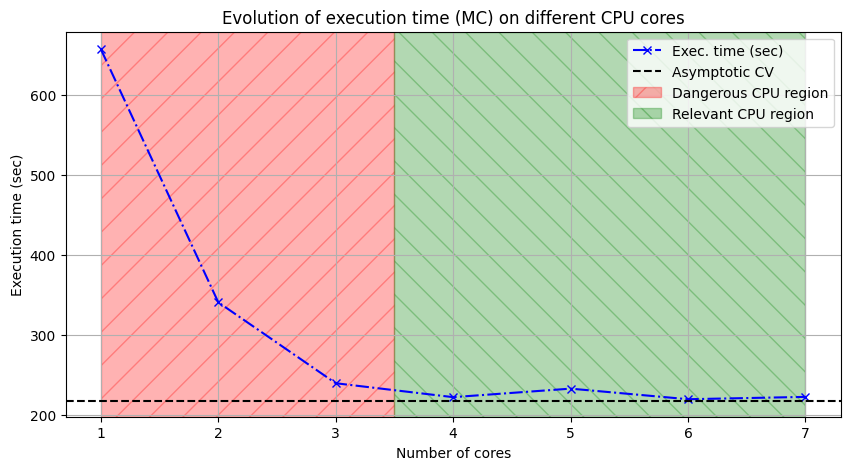

In [61]:
_ = d.plot(label="Exec. time (sec)", ls="-.", marker="x")
_ = plt.axhline(y = d.min() - 2, color="black", ls="--", label="Asymptotic CV")
_ = plt.axvspan(xmin = 1, xmax = 3.5, color="red", alpha=0.3, label="Dangerous CPU region", hatch="/")
_ = plt.axvspan(xmin = 3.5, xmax = 7, color="green", alpha=0.3, label="Relevant CPU region", hatch="\\")
_ = plt.xlabel("Number of cores")
_ = plt.ylabel("Execution time (sec)")
_ = plt.grid()
_ = plt.legend()
_ = plt.title("Evolution of execution time (MC) on different CPU cores")

### Miscellaneous

#### Plot of the underlying price $(S_t)_t$ and rate $(r_t)_t$

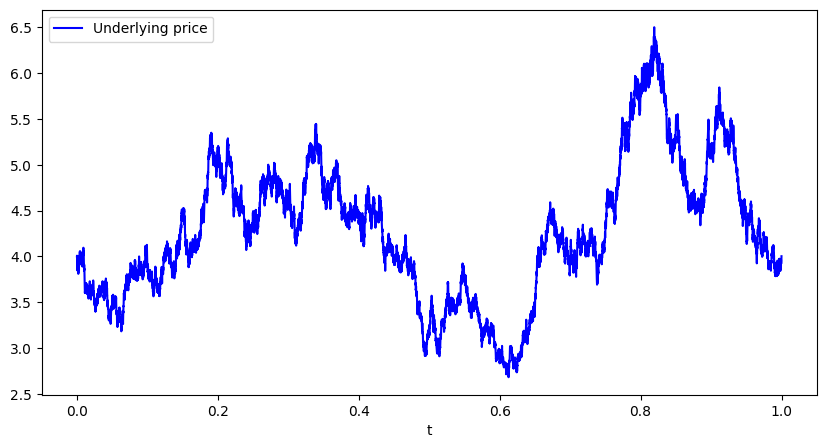

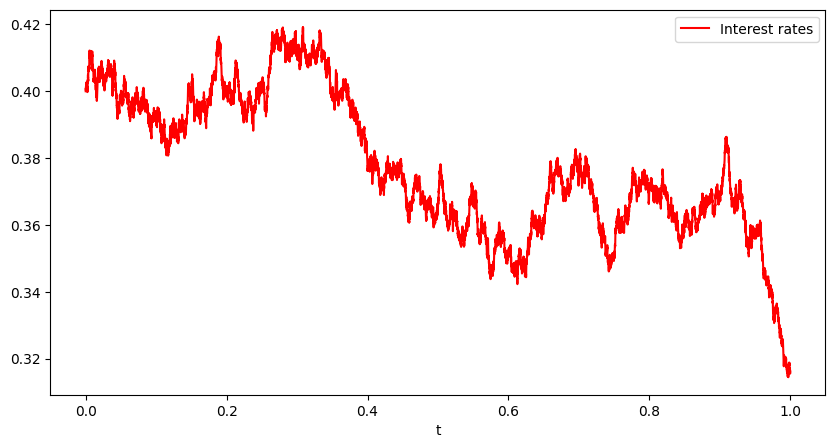

In [24]:
# Plotting underlying price and rates
_ = ep.trajectories[1].plot(y="S", x = "t", label="Underlying price", color="blue")
_ = ep.trajectories[1].plot(y="r", x = "t", label="Interest rates", color="red")

#### Plot of confidence intervals distribution

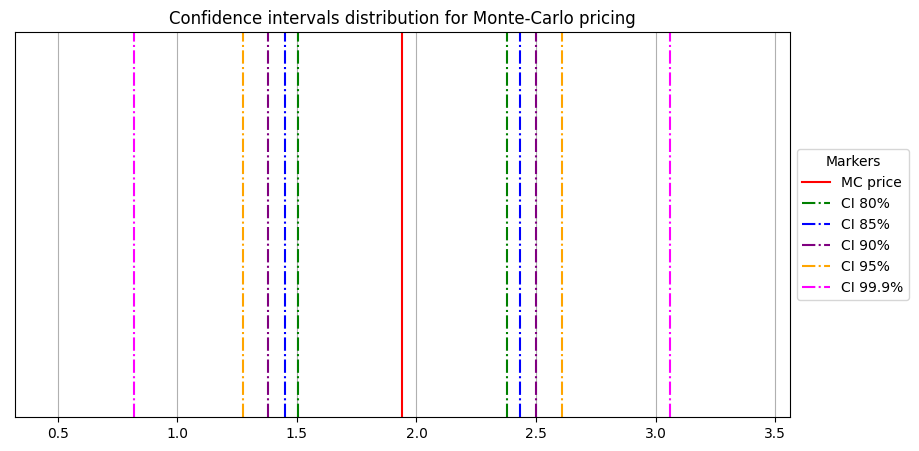

In [25]:
# Plot confidence intervals
Utils.plot_confidence_intervals(pricer_res)

#### Plot the evolution of MC convergence over $N_{MC} \uparrow +\infty$ 

In [26]:
# SECURITY TRIGGER
PERFORM_SIMULATION = False

if PERFORM_SIMULATION:
    print("Conducting simulation")
    N_MC_ = np.arange(10, 350, 5)
    K = 2
    data = {N_MC: {"price": None, "ci": None, "exec_time": None} for N_MC in N_MC_}
    for N_MC in N_MC_:
        print(f"Processing:\t {N_MC}")
        ep.isSimulated = False
        # Computing the call price using Monte-Carlo simulation
        start_time = time.time()
        pricer_res = ep.compute_option_price(K=K, 
                                             contract=Constants.Contract.CALL, 
                                             ci_levels=[
                                                 Constants.Level.LEVEL_80, 
                                                 Constants.Level.LEVEL_85, 
                                                 Constants.Level.LEVEL_90
                                             ], N_MC=N_MC)
        end_time = time.time()
        duration = end_time - start_time

        # Retrieving the output from computations
        price, ci = Utils.get_dict_values(pricer_res)
        data[N_MC]["price"] = price
        data[N_MC]["ci"] = ci
        data[N_MC]["exec_time"] = duration

    # Saving the execution metrics
    a = pd.DataFrame(data)
    a.head()

    # Saving on-disk the execution metrics
    a.to_pickle("../export/CV_MC.pkl")
else:
    print("Reading simulation export")
    a = pd.read_pickle("../export/CV_MC.pkl")

# Retrieving the CI levels
ci = a.T["ci"].iloc[0]

Reading simulation export


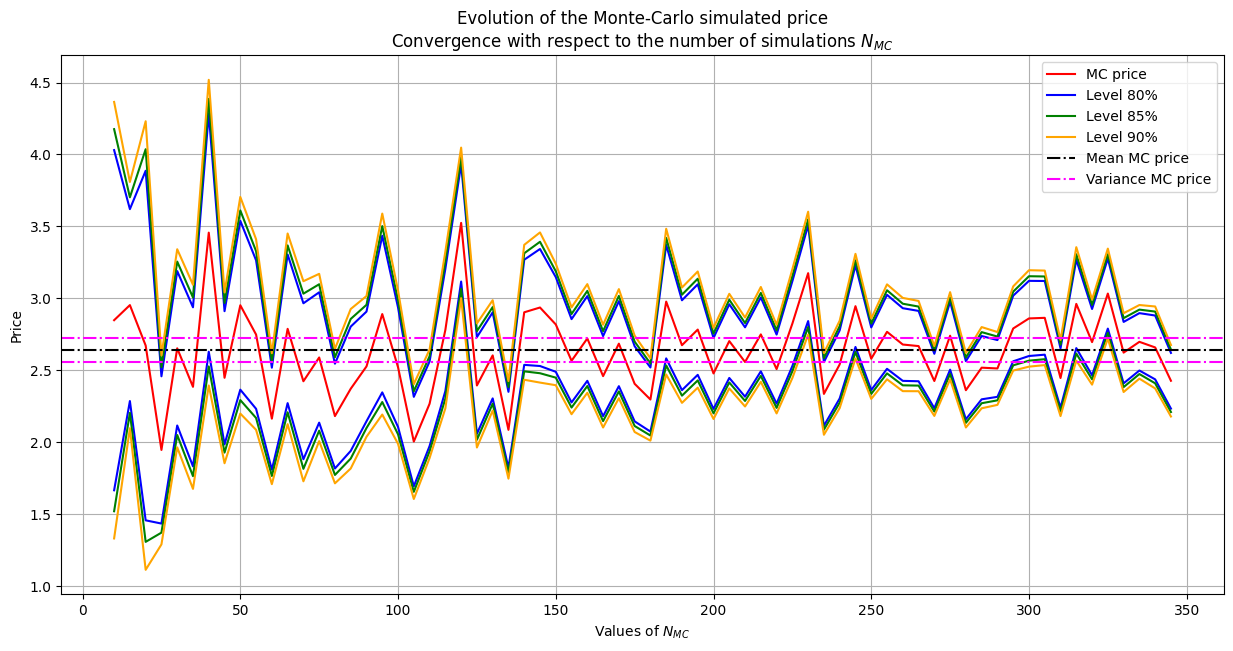

In [27]:
# Plotting
a.T["price"].plot(figsize=(15, 7), color="red", label="MC price")
colors = ["blue", "green", "orange", "purple", "magenta"]
for i, ci_level in enumerate(list(ci.keys())):
    a.T["ci"].apply(pd.Series)[ci_level].apply(pd.Series)["lower"].plot(color=colors[i], label=f"Level {ci_level}%")
    a.T["ci"].apply(pd.Series)[ci_level].apply(pd.Series)["upper"].plot(color=colors[i], label="")
_ = plt.axhline(y = a.T["price"].mean(), color="black", ls="-.", label="Mean MC price")
_ = plt.axhline(y = a.T["price"].mean() - a.T["price"].var(), color="magenta", ls="-.", label="Variance MC price")
_ = plt.axhline(y = a.T["price"].mean() + a.T["price"].var(), color="magenta", ls="-.", label="")
_ = plt.xlabel("Values of $N_{MC}$")
_ = plt.ylabel("Price")
_ = plt.title("Evolution of the Monte-Carlo simulated price\nConvergence with respect to the number of simulations $N_{MC}$")
_ = plt.legend()
_ = plt.grid()

## Asian option pricer

In [28]:
# Model parameters
S0 = 4
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

### Serial MC

In [29]:
# Define the Asian pricer
ap = AsianPricer(udl_model=model, preCompute=True, N_MC=10)

Pre-computing the equity trajectories


Sim. progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
ap

In [26]:
# Boolean representing whether the simulations have already been simulated
ap.isSimulated

True

In [31]:
K = 1.3 # Defining a strike price
# Call price
pricer_res = ap.compute_option_price(K=K, 
                                     contract=Constants.Contract.CALL, 
                                     ci_levels=[
                                         Constants.Level.LEVEL_80, 
                                         Constants.Level.LEVEL_85, 
                                         Constants.Level.LEVEL_90,
                                         Constants.Level.LEVEL_95,
                                         Constants.Level.LEVEL_99_9
                                     ])

Required CI levels:  [80, 85, 90, 95, 99.9]


In [32]:
# Call price
ap.compute_option_price_call(K)

Required CI levels:  [95]


{'price': 2.341248372055492,
 'ci': {95: {'lower': 1.9170652661285645,
   'upper': 2.7654314779824194,
   'radius': 0.4241831059269275}}}

In [37]:
# Put price
ap.compute_option_price_put(K)

Required CI levels:  [95]


{'price': 0.0, 'ci': {95: {'lower': 0.0, 'upper': 0.0, 'radius': 0.0}}}

### Parallel MC

$\longrightarrow$ Same as European pricer section

### Miscellaneous

#### Plot of the underlying price $(S_t)_t$ and rate $(r_t)_t$

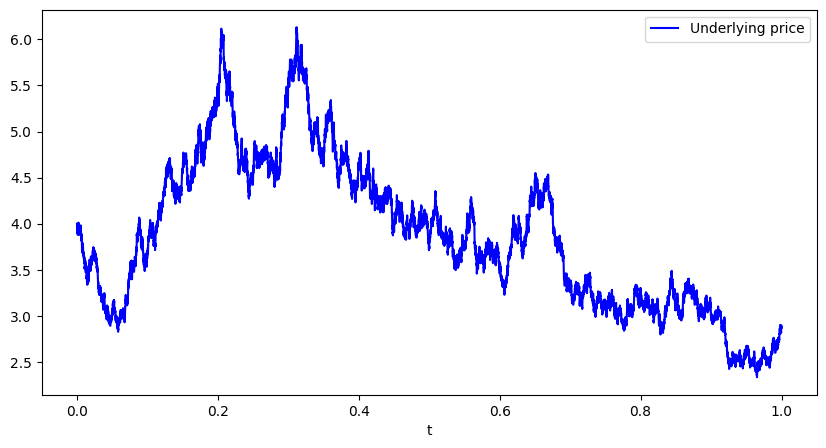

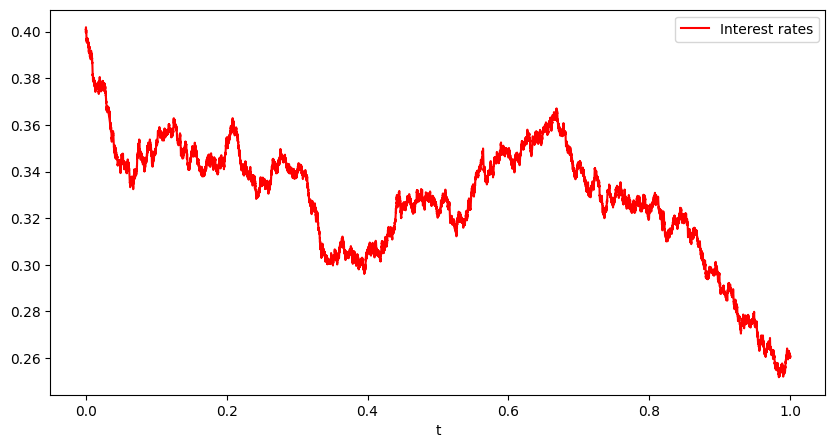

In [35]:
# Plotting underlying price and rates
_ = ap.trajectories[1].plot(y="S", x = "t", label="Underlying price", color="blue")
_ = ap.trajectories[1].plot(y="r", x = "t", label="Interest rates", color="red")